# Neural & Behavioral Modeling - Week 12 (Exercises)
by 黃翔易 (b08303047@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim

In [2]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
Device  0 : Tesla T4
Current: Device  0


## 1. RNN on images (4 points)
Note that the RNN-based MNIST classifier in 2.1.1 of model_12_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

In [3]:
# Thoe model in 2.1.1 of 12_examples.ipynb:

class RNN_Old(nn.Module):
    def __init__(self):
        super(RNN_Old, self).__init__()
        self.rnn = nn.RNN(input_size = 28, hidden_size = 128, num_layers = 1, batch_first = True)
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

In [4]:
# RNN with Softmax:

class RNN_New(nn.Module):
    def __init__(self):
        super(RNN_New, self).__init__()
        self.rnn = nn.RNN(input_size = 28, hidden_size = 128, num_layers = 1, batch_first = True)
        self.classifier = nn.Linear(128,10)
        self.softmax = nn.Softmax(dim = 1) # add Softmax
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        output = self.softmax(output) # add Softmax

        return output

In [6]:
# input dataset:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data", transform = transform, train = True, download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST(root = "./data", transform = transform, train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [42]:
from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total

def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [43]:
# compare the two results:
print('RNN without Softmax: ')
srn_old = RNN_Old()
optimizer_old = optim.Adam(srn_old.parameters())
criterion_old = nn.CrossEntropyLoss()
train(device, srn_old, train_data, test_data, 3, optimizer_old, criterion_old)

print('----------')

print('RNN with Softmax: ')
srn_new = RNN_New()
optimizer_new = optim.Adam(srn_new.parameters())
criterion_new = nn.CrossEntropyLoss()
train(device, srn_new, train_data, test_data, 3, optimizer_new, criterion_new)

RNN without Softmax: 
Epoch 0. Train Loss: 0.741881, Train Acc: 0.754897, Valid Loss: 0.417929, Valid Acc: 0.877687, Time 00:00:11
Epoch 1. Train Loss: 0.320613, Train Acc: 0.908782, Valid Loss: 0.229018, Valid Acc: 0.936107, Time 00:00:13
Epoch 2. Train Loss: 0.226143, Train Acc: 0.936884, Valid Loss: 0.334650, Valid Acc: 0.896198, Time 00:00:12
----------
RNN with Softmax: 
Epoch 0. Train Loss: 1.830643, Train Acc: 0.640259, Valid Loss: 1.677620, Valid Acc: 0.787221, Time 00:00:11
Epoch 1. Train Loss: 1.647246, Train Acc: 0.819530, Valid Loss: 1.614393, Valid Acc: 0.850119, Time 00:00:12
Epoch 2. Train Loss: 1.601190, Train Acc: 0.863140, Valid Loss: 1.580710, Valid Acc: 0.884654, Time 00:00:14


## 討論：
1. 加入 Softmax 以後，表現下降。不僅是 train/valid loss 都增加，且 train/valid accuracy 也都下降了。
2. 討論其原因：
  * 理論上，多分類問題加入了 softmax 的表現應該會更好才對，因為 softmax 是要挑選出多種分類中出現機率最高的。
  * 而造成表現變差的原因在於 nn.CrossEntropyLoss() 已經內含 softmax 的運算了：「This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.」
  * 故，再加入 softmax 等於是做了兩次的 softmax，這會造成結果更差。因此，不用再加 softmax 了。

## 2. RNN v.s. CNN (4 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in model_12_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

In [55]:
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')

In [87]:
# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
ts = list(map(lambda x: x / scalar, ts))

# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(ts)

# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

In [21]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [26]:
# NEW CLASS:
class rnn_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(rnn_reg, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

Epoch: 100, Loss: 0.00421
Epoch: 200, Loss: 0.00360
Epoch: 300, Loss: 0.00156
Epoch: 400, Loss: 0.00123
Epoch: 500, Loss: 0.00044
Epoch: 600, Loss: 0.00021
Epoch: 700, Loss: 0.00013
Epoch: 800, Loss: 0.00011
Epoch: 900, Loss: 0.00010
Epoch: 1000, Loss: 0.00009
torch.Size([142, 1, 1]) (142,) 144
Processing time: 30.313235759735107 sec.


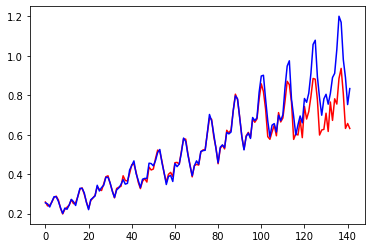

In [88]:
# 2.2.1 (RNN: LSTM):
import time

net = lstm_reg(input_size=2, hidden_size=10)
# net = rnn_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
start = time.time()

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
new_data = pred_test2 # new data used for new training
end = time.time()
print(pred_test1.shape, pred_test2.shape, len(ts))
print(f'Processing time: {end - start} sec.')

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

Epoch: 100, Loss: 0.00387
Epoch: 200, Loss: 0.00252
Epoch: 300, Loss: 0.00198
Epoch: 400, Loss: 0.00159
Epoch: 500, Loss: 0.00159
Epoch: 600, Loss: 0.00142
Epoch: 700, Loss: 0.00165
Epoch: 800, Loss: 0.00151
Epoch: 900, Loss: 0.00141
Epoch: 1000, Loss: 0.00129
torch.Size([142, 1, 1]) (142,) 144
Processing time: 11.9498929977417 sec.


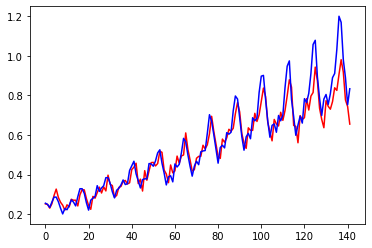

In [30]:
# 2.2.1 (RNN: RNN):

# net = lstm_reg(input_size=2, hidden_size=10)
net = rnn_reg(input_size=2, hidden_size=10) # use rnn module
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
start = time.time()

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
end = time.time()
print(pred_test1.shape, pred_test2.shape, len(ts))
print(f'Processing time: {end - start} sec.')

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

In [17]:
class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size):
        super(cnn_reg, self).__init__()
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x=x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x

Epoch: 100, Loss: 0.00612
Epoch: 200, Loss: 0.00242
Epoch: 300, Loss: 0.00219
Epoch: 400, Loss: 0.00203
Epoch: 500, Loss: 0.00195
Epoch: 600, Loss: 0.00191
Epoch: 700, Loss: 0.00190
Epoch: 800, Loss: 0.00190
Epoch: 900, Loss: 0.00190
Epoch: 1000, Loss: 0.00190
torch.Size([142, 1]) (142,) 144
Processing time: 0.8614828586578369 sec.


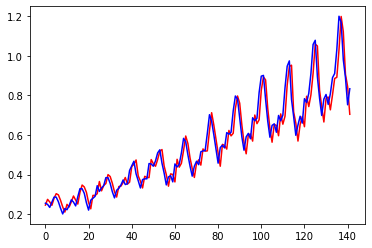

In [47]:
# 2.3.1 (CNN):

# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
start = time.time()

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
end = time.time()
print(pred_test1.shape, pred_test2.shape, len(ts))
print(f'Processing time: {end - start} sec.')

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

## 討論：
1. CNN 的執行速度比 RNN（LSTM） 還要快。
2. 從圖來看，前 70 % 資料是訓練集，後 30% 是測試集，而從 training loss 來看，RNN（LSTM） 的 training loss 比較小。
3. 換言之， 在前 70 % 的表現是 RNN（LSTM） 比較好，但後 30% 測試集是 CNN 的預測正確率比較好。
4. 而將 lstm_reg 換成 rnn_reg，預測結果似乎有變好一點，但 training loss 也稍微變大。
5. 仔細觀察可發現，RNN（LSTM） 預測不好的原因主要是在圖形的漲幅跟不上實際的資料，而 CNN 雖然預測的比較好，但在時間軸上，CNN 的預測其實都慢半拍（紅色線都在藍色線偏右）。
6. 造成 1D-CNN 的表現較好的原因可能有幾個：
  * 這裡的資料量只有 142/144 個，實在太少。
  * 1D-CNN 適合用來預測具有重複規律的資料，如季節資料。
  * RNN 較適合用來預測非固定長度的資料，CNN 則適合預測固定長度的資料。
7. 但也許是資料集在短時間成長幅度太大的問題，所以，將 RNN（LSTM）預測出來的資料當成新的資料集來預測，看看會發生什麼事情。

## NEW DATASET:

In [89]:
# NEW DATASET:
data_new = []
for i in new_data:
    data_new.append([i])

data_X, data_Y = create_dataset(data_new)

# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

Epoch: 100, Loss: 0.00437
Epoch: 200, Loss: 0.00356
Epoch: 300, Loss: 0.00318
Epoch: 400, Loss: 0.00257
Epoch: 500, Loss: 0.00087
Epoch: 600, Loss: 0.00090
Epoch: 700, Loss: 0.00010
Epoch: 800, Loss: 0.00005
Epoch: 900, Loss: 0.00003
Epoch: 1000, Loss: 0.00003
torch.Size([140, 1, 1]) (140,) 144
Processing time: 25.941770315170288 sec.


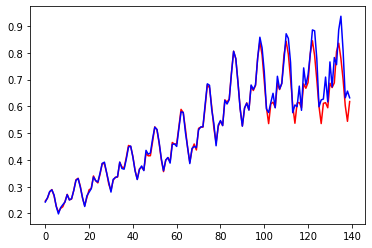

In [90]:
# 2.2.1 (RNN: LSTM):
import time

net = lstm_reg(input_size=2, hidden_size=10)
# net = rnn_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
start = time.time()

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
end = time.time()
print(pred_test1.shape, pred_test2.shape, len(ts))
print(f'Processing time: {end - start} sec.')

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(data_new[2:], 'b', label='real');

Epoch: 100, Loss: 0.00235
Epoch: 200, Loss: 0.00207
Epoch: 300, Loss: 0.00193
Epoch: 400, Loss: 0.00190
Epoch: 500, Loss: 0.00190
Epoch: 600, Loss: 0.00190
Epoch: 700, Loss: 0.00190
Epoch: 800, Loss: 0.00190
Epoch: 900, Loss: 0.00190
Epoch: 1000, Loss: 0.00190
torch.Size([140, 1]) (140,) 144
Processing time: 0.7684996128082275 sec.


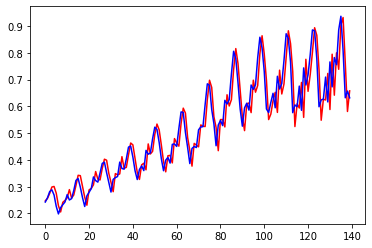

In [91]:
# 2.3.1 (CNN):

# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
start = time.time()

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
end = time.time()
print(pred_test1.shape, pred_test2.shape, len(ts))
print(f'Processing time: {end - start} sec.')

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(data_new[2:], 'b', label='real');

## 討論2:
1. 這次 RNN（LSTM）學得更好了，training loss 變得更小。
2. 這次 RNN（LSTM）的預測看起來也有變好很多，而 CNN 還是一樣不錯。
3. 因此，很有可能如前述，在資料量太小的情況下，資料集的變化幅度過快，使得 RNN（LSTM）沒辦法學得很好，而修正資料集以後，就有好一點。
4. 不過，還是能觀察到 RNN（LSTM）預測的數值還是會偏低（紅線低於藍線）。
